[*********************100%%**********************]  1 of 1 completed


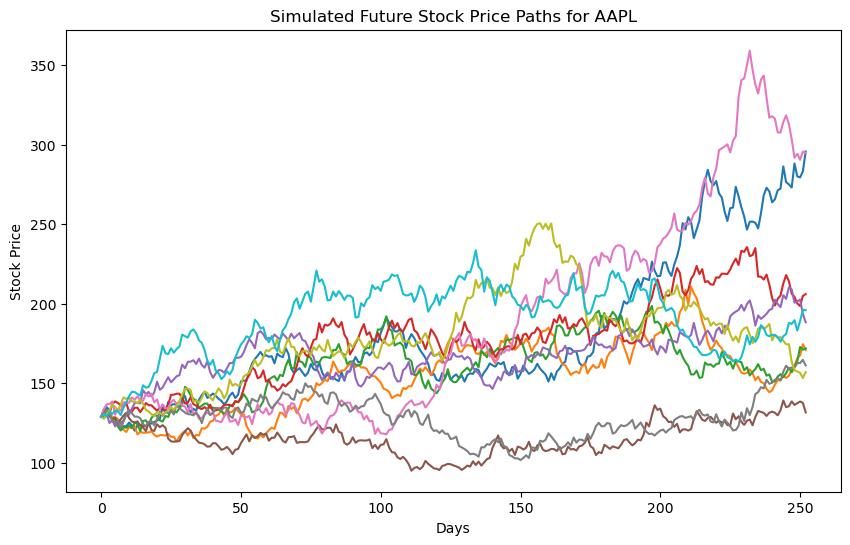

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Fetch historical stock data
ticker = 'AAPL'  # Example: Apple Inc.
data = yf.download(ticker, start="2020-01-01", end="2023-01-01")
data['Returns'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))

# Calculate the mean and standard deviation of the returns
daily_returns = data['Returns'].dropna()
mean_return = daily_returns.mean()
std_dev_return = daily_returns.std()

# Parameters for simulation
initial_stock_price = data['Adj Close'][-1]  # Last available price
annual_volatility = std_dev_return * np.sqrt(252)  # Annualize the daily standard deviation
drift = (mean_return * 252) + (0.5 * annual_volatility**2)  # Annual drift using mean of returns
time_horizon = 1  # Time horizon in years
days = 252  # Number of trading days in a year
dt = time_horizon / days  # Time increment
simulations = 1000  # Number of Monte Carlo simulations

# Simulate future stock prices
np.random.seed(42)
stock_prices = np.zeros((days + 1, simulations))
stock_prices[0] = initial_stock_price

for t in range(1, days + 1):
    brownian_motion = np.random.normal(0, 1, simulations)
    stock_prices[t] = stock_prices[t-1] * np.exp((drift - 0.5 * annual_volatility**2) * dt +
                                                 annual_volatility * np.sqrt(dt) * brownian_motion)

# Plot the first 10 simulations
plt.figure(figsize=(10, 6))
for i in range(10):
    plt.plot(stock_prices[:, i])
plt.title('Simulated Future Stock Price Paths for ' + ticker)
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.show()


Portfolio Start Value: $12904.31
Value at Risk (VaR) at 95% confidence: $4375.79
Conditional Value at Risk (CVaR) at 95% confidence: $5612.19


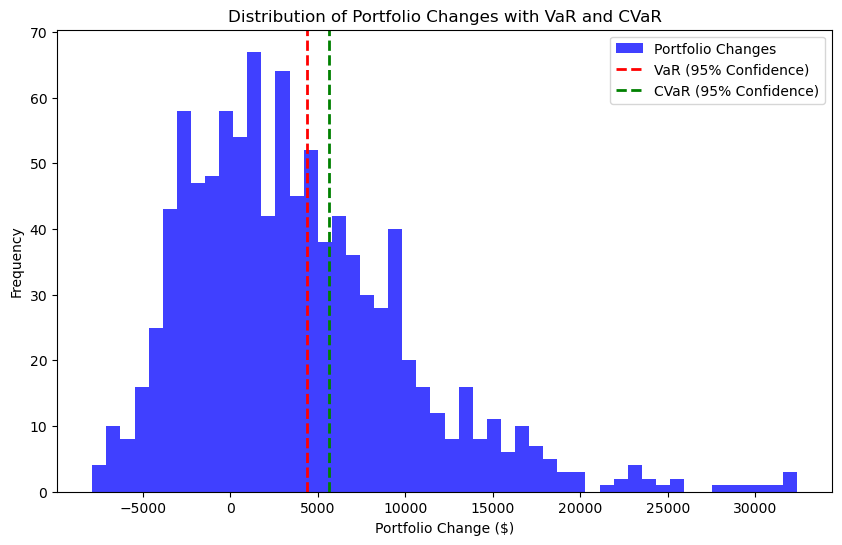

In [2]:
# Number of shares in the portfolio (example)
num_shares = 100

# Calculate portfolio value at the start and end of the simulation period
portfolio_start = initial_stock_price * num_shares
portfolio_end = stock_prices[-1, :] * num_shares
portfolio_changes = portfolio_end - portfolio_start

# Calculate VaR and CVaR
confidence_level = 0.95
sorted_changes = np.sort(portfolio_changes)
var_index = int((1 - confidence_level) * simulations)
value_at_risk = -sorted_changes[var_index]  # Negative because we're looking at losses
conditional_value_at_risk = -np.mean(sorted_changes[:var_index])

# Output the results
print("Portfolio Start Value: ${:.2f}".format(portfolio_start))
print("Value at Risk (VaR) at {}% confidence: ${:.2f}".format(int(confidence_level * 100), value_at_risk))
print("Conditional Value at Risk (CVaR) at {}% confidence: ${:.2f}".format(int(confidence_level * 100), conditional_value_at_risk))

# Plotting the distribution of portfolio changes
plt.figure(figsize=(10, 6))
plt.hist(portfolio_changes, bins=50, alpha=0.75, color='blue', label='Portfolio Changes')
plt.axvline(value_at_risk, color='red', linestyle='dashed', linewidth=2, label='VaR (95% Confidence)')
plt.axvline(conditional_value_at_risk, color='green', linestyle='dashed', linewidth=2, label='CVaR (95% Confidence)')
plt.title('Distribution of Portfolio Changes with VaR and CVaR')
plt.xlabel('Portfolio Change ($)')
plt.ylabel('Frequency')
plt.legend()
plt.show()